In [ ]:
# Downgrade numpy to a version compatible with surprise
!pip install 'numpy<2'

In [ ]:
# Install the 'surprise' library for recommendation algorithms
!pip install scikit-surprise

  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2544628 sha256=a07bddb71ab84743ba630c8894f66d84945cdd64d31d108ae95775dd22d98b23
  Stored in directory: /root/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, KNNBasic, SVD
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy
import lightgbm as lgb
import requests
import zipfile
import io

In [ ]:
# Download and unzip the MovieLens 100K dataset [cite: 25, 27]
url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
print("Downloading MovieLens dataset...")
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()
print("Dataset downloaded and unzipped.")

Dataset downloaded and unzipped.


In [ ]:
# Load datasets into pandas DataFrames
movies_df = pd.read_csv('ml-latest-small/movies.csv')
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')

In [ ]:
# Merge for easier data handling
df = pd.merge(ratings_df, movies_df, on='movieId')

print("\nFirst 5 rows of the merged data:")
print(df.head())
print("\nSetup and data preparation complete.\n")


First 5 rows of the merged data:
   userId  movieId  rating  timestamp                        title  \
0       1        1     4.0  964982703             Toy Story (1995)   
1       1        3     4.0  964981247      Grumpier Old Men (1995)   
2       1        6     4.0  964982224                  Heat (1995)   
3       1       47     5.0  964983815  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0  964982931   Usual Suspects, The (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                               Comedy|Romance  
2                        Action|Crime|Thriller  
3                             Mystery|Thriller  
4                       Crime|Mystery|Thriller  

Setup and data preparation complete.



In [ ]:
# Calculate average rating and number of ratings
movie_stats = df.groupby('title')['rating'].agg(['mean', 'count'])
movie_stats.rename(columns={'mean': 'avg_rating', 'count': 'num_ratings'}, inplace=True)

In [ ]:
# Set a threshold for minimum number of ratings (e.g., 90th percentile)
min_ratings_threshold = movie_stats['num_ratings'].quantile(0.90)

In [ ]:
# Filter out movies below the threshold
popular_movies = movie_stats[movie_stats['num_ratings'] >= min_ratings_threshold]

In [ ]:
# Sort by average rating to get the top recommendations
top_popular_movies = popular_movies.sort_values('avg_rating', ascending=False)

In [ ]:
print(f"\nMinimum ratings required for a movie to be recommended: {int(min_ratings_threshold)}")
print("\n--- Top 10 Popular Movie Recommendations ---")
print(top_popular_movies.head(10))
print("\nBaseline model implementation complete.\n")


Minimum ratings required for a movie to be recommended: 27

--- Top 10 Popular Movie Recommendations ---
                                                    avg_rating  num_ratings
title                                                                      
Shawshank Redemption, The (1994)                      4.429022          317
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)         4.333333           27
Philadelphia Story, The (1940)                        4.310345           29
Lawrence of Arabia (1962)                             4.300000           45
Hoop Dreams (1994)                                    4.293103           29
Godfather, The (1972)                                 4.289062          192
Fight Club (1999)                                     4.272936          218
Cool Hand Luke (1967)                                 4.271930           57
Dr. Strangelove or: How I Learned to Stop Worry...    4.268041           97
Rear Window (1954)                                    4.26

--- Data Visualization ---


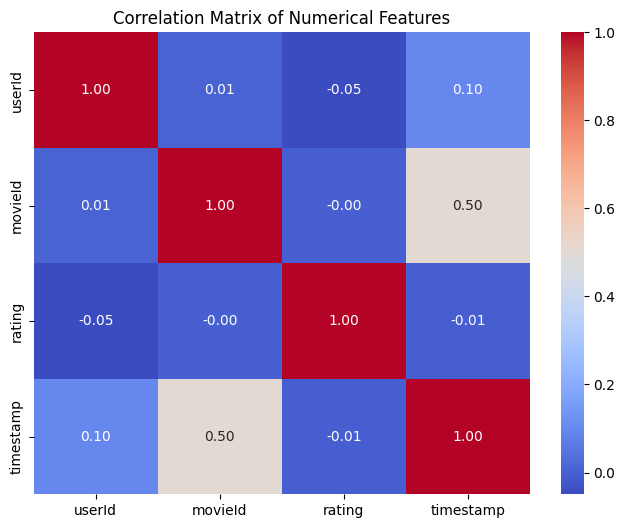


Correlation matrix visualization complete.


In [ ]:
# --- Data Visualization ---
print("--- Data Visualization ---")

# Select numerical columns for correlation matrix
df_numerical = df[['userId', 'movieId', 'rating', 'timestamp']]

# Calculate the correlation matrix
correlation_matrix = df_numerical.corr()

# Plot the correlation matrix using a heatmap
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

print("\nCorrelation matrix visualization complete.")


--- Scatterplots of Numerical Features ---


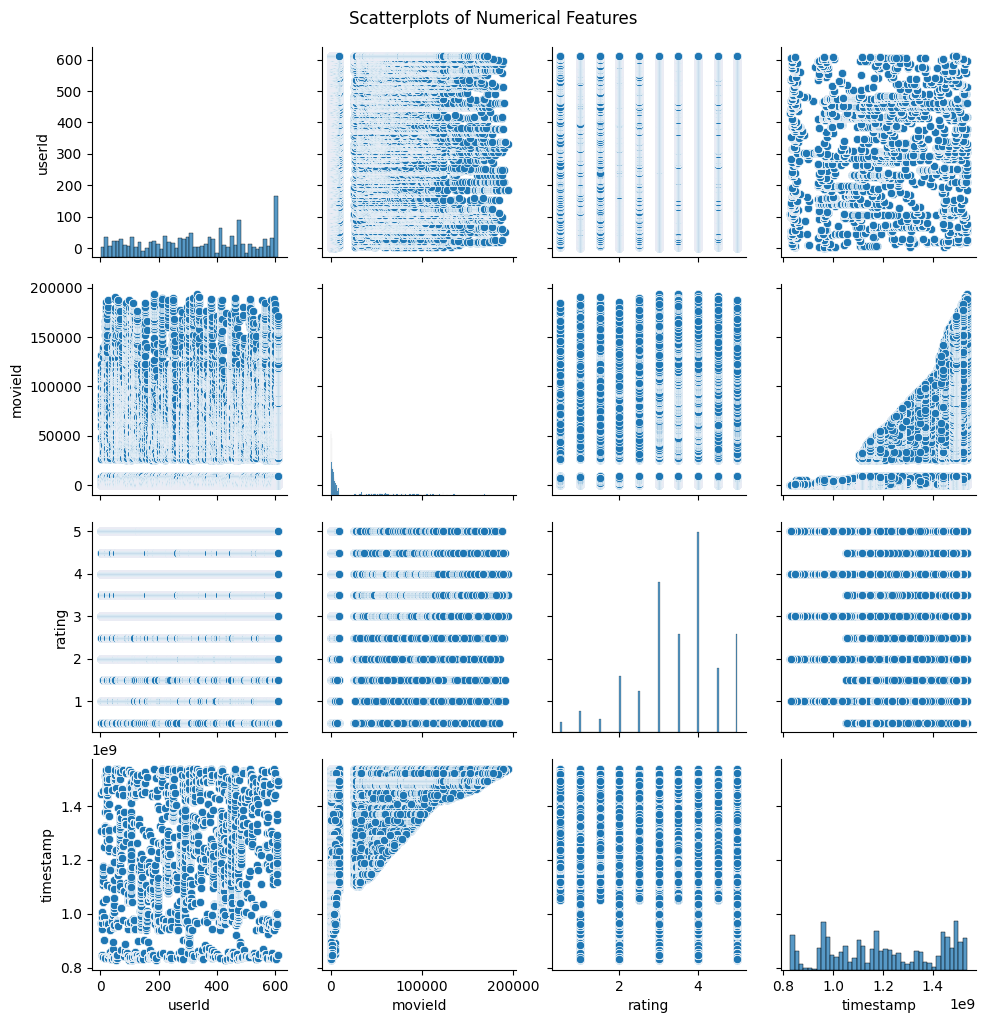


Scatterplots complete.


In [ ]:
# Generate scatterplots for pairs of numerical features
print("\n--- Scatterplots of Numerical Features ---")
sns.pairplot(df_numerical)
plt.suptitle('Scatterplots of Numerical Features', y=1.02)
plt.show()
print("\nScatterplots complete.")


--- Histograms of Numerical Features ---


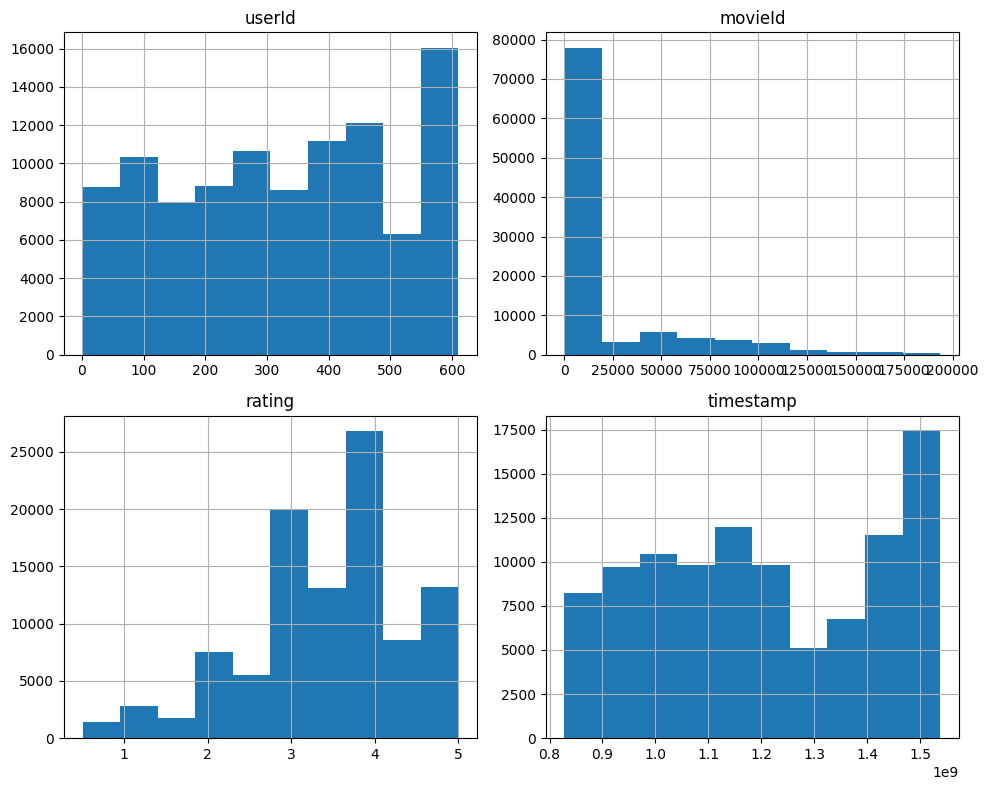


Histograms complete.


In [ ]:
# Generate histograms for numerical features
print("\n--- Histograms of Numerical Features ---")
df_numerical.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()
print("\nHistograms complete.")


--- Boxplots of Numerical Features ---


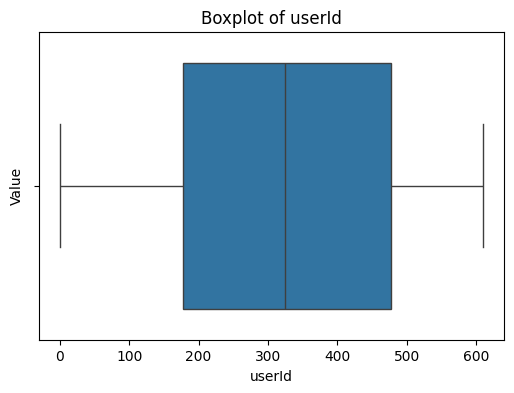

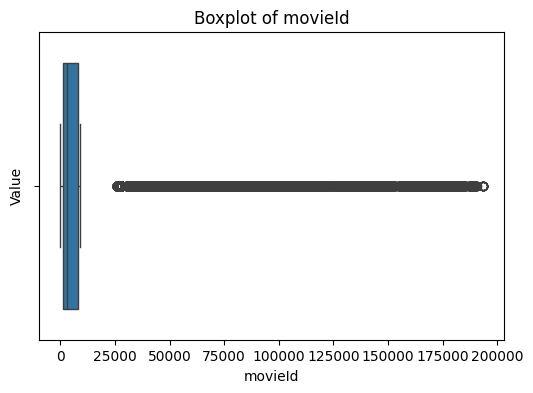

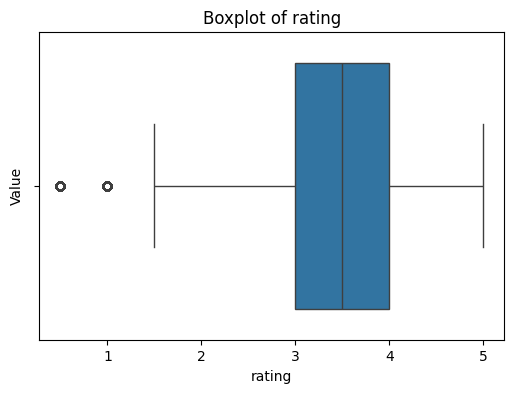

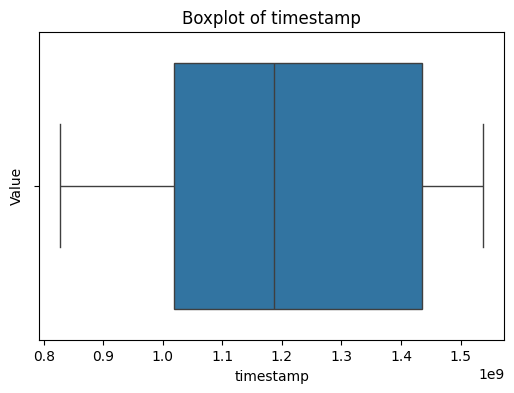


Boxplots complete.


In [ ]:
# Generate individual boxplots for numerical features
print("\n--- Boxplots of Numerical Features ---")
for col in df_numerical.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df_numerical[col])
    plt.title(f'Boxplot of {col}')
    plt.ylabel('Value')
    plt.show()
print("\nBoxplots complete.")

In [ ]:
# Load data for the surprise library
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

In [ ]:
# Split data into training and testing sets for evaluation
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
# Configure and train the KNN model (user-based collaborative filtering) [cite: 31, 34]
print("Training the KNN model...")
sim_options = {'name': 'cosine', 'user_based': True}
knn_model = KNNBasic(sim_options=sim_options)
knn_model.fit(trainset)
print("Training complete.")

Training the KNN model...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Training complete.


In [ ]:
import numpy as np

def ndcg_at_k(true_relevance, predicted_scores, k):
  """
  Calculates the Normalized Discounted Cumulative Gain (NDCG) at k.

  Args:
    true_relevance: A list of true relevance scores for the items.
    predicted_scores: A list of predicted scores for the items.
    k: The number of top items to consider.

  Returns:
    The NDCG@k score.
  """
  # Sort items by predicted score
  top_k_indices = np.argsort(predicted_scores)[::-1][:k]

  # Get the true relevance of the top k items
  top_k_true_relevance = np.take(true_relevance, top_k_indices)

  # Calculate DCG
  gains = 2**top_k_true_relevance - 1
  discounts = np.log2(np.arange(len(top_k_true_relevance)) + 2)
  dcg = np.sum(gains / discounts)

  # Calculate IDCG
  ideal_order = np.sort(true_relevance)[::-1]
  ideal_gains = 2**ideal_order[:k] - 1
  ideal_discounts = np.log2(np.arange(len(ideal_gains)) + 2)
  idcg = np.sum(ideal_gains / ideal_discounts)

  if idcg == 0:
      return 0

  return dcg / idcg

In [ ]:
def mrr_at_k(true_relevance, predicted_scores, k):
  """
  Calculates the Mean Reciprocal Rank (MRR) at k.

  Args:
    true_relevance: A list of true relevance scores (1 for relevant, 0 for not).
    predicted_scores: A list of predicted scores for the items.
    k: The number of top items to consider.

  Returns:
    The MRR@k score.
  """
  # Sort items by predicted score
  top_k_indices = np.argsort(predicted_scores)[::-1][:k]

  # Find the rank of the first relevant item
  for i, index in enumerate(top_k_indices):
    if true_relevance[index] == 1:
      return 1 / (i + 1)

  return 0

### Mean Reciprocal Rank (MRR)

The Mean Reciprocal Rank (MRR) is an evaluation metric for ranking-based tasks. It measures the average of the reciprocal ranks of the first relevant item in a set of ranked results.

**Formula:**

$$ MRR = \frac{1}{|U|} \sum_{u=1}^{|U|} \frac{1}{rank_u} $$

Where:
- $|U|$ is the number of users.
- $rank_u$ is the rank of the first relevant item for user $u$.

A higher MRR indicates that the first relevant item is ranked higher on average across all users.

In [ ]:
def mrr_at_k(true_relevance, predicted_scores, k):
  """
  Calculates the Mean Reciprocal Rank (MRR) at k.

  Args:
    true_relevance: A list of true relevance scores (1 for relevant, 0 for not).
    predicted_scores: A list of predicted scores for the items.
    k: The number of top items to consider.

  Returns:
    The MRR@k score.
  """
  # Sort items by predicted score
  top_k_indices = np.argsort(predicted_scores)[::-1][:k]

  # Find the rank of the first relevant item
  for i, index in enumerate(top_k_indices):
    if true_relevance[index] == 1:
      return 1 / (i + 1)

  return 0

In [ ]:
# --- Train a collaborative filtering model (SVD) ---
# Load the data into the surprise format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# Train the SVD model
trainset = data.build_full_trainset()
model = SVD()
model.fit(trainset)

print("SVD model trained successfully!")

SVD model trained successfully!


In [ ]:
# --- Create User Features ---
# This will be used by the LightGBM model

user_features = ratings_df.groupby('userId').agg(
    mean_rating=('rating', 'mean'),
    num_ratings=('rating', 'count')
).reset_index()

print("User features created successfully:")
print(user_features.head())

User features created successfully:
   userId  mean_rating  num_ratings
0       1     4.366379          232
1       2     3.948276           29
2       3     2.435897           39
3       4     3.555556          216
4       5     3.636364           44


In [ ]:
# --- Create Movie Features ---
# This will also be used by the LightGBM model

# Split the genres string into a list of genres
movies_df['genres_list'] = movies_df['genres'].str.split('|')

# Use one-hot encoding to create a feature for each genre
movie_features = movies_df['genres_list'].str.join('|').str.get_dummies()

# Add the movieId to this features DataFrame
movie_features['movieId'] = movies_df['movieId']

# Display the first few rows of your new movie_features DataFrame
print("Movie features created successfully:")
print(movie_features.head())

Movie features created successfully:
   (no genres listed)  Action  Adventure  Animation  Children  Comedy  Crime  \
0                   0       0          1          1         1       1      0   
1                   0       0          1          0         1       0      0   
2                   0       0          0          0         0       1      0   
3                   0       0          0          0         0       1      0   
4                   0       0          0          0         0       1      0   

   Documentary  Drama  Fantasy  ...  Horror  IMAX  Musical  Mystery  Romance  \
0            0      0        1  ...       0     0        0        0        0   
1            0      0        1  ...       0     0        0        0        0   
2            0      0        0  ...       0     0        0        0        1   
3            0      1        0  ...       0     0        0        0        1   
4            0      0        0  ...       0     0        0        0        0   

 

In [ ]:
def get_top_n_lgbm_recommendations(model, user_id, n=10, user_features_df=user_features, movie_features_df=movie_features, ratings_df=ratings_df, movies_df=movies_df):
    """
    Generates top-N movie recommendations for a user using a trained LightGBM model.
    """
    # Get all movie IDs the user has NOT rated
    rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()
    all_movies = movies_df['movieId'].unique()
    unrated_movies = [movie for movie in all_movies if movie not in rated_movies]

    # Create a dataframe of unrated movies for the user
    unrated_df = pd.DataFrame({'userId': user_id, 'movieId': unrated_movies})

    # Merge with user and movie features
    unrated_with_features = pd.merge(unrated_df, user_features_df[user_features_df['userId'] == user_id], on='userId')
    unrated_with_features = pd.merge(unrated_with_features, movie_features_df, on='movieId')

    # Prepare data for prediction
    X_predict = unrated_with_features.drop(columns=['userId', 'movieId'])

    # Predict ratings
    predicted_ratings = model.predict(X_predict)

    # Add predicted ratings back to the dataframe
    unrated_with_features['predicted_rating'] = predicted_ratings

    # Sort by predicted rating and get top N
    top_n_recs_df = unrated_with_features.sort_values('predicted_rating', ascending=False).head(n)

    # Get the movie titles and genres
    top_n_movie_ids = top_n_recs_df['movieId'].tolist()
    return movies_df[movies_df['movieId'].isin(top_n_movie_ids)]

print("Function to get LightGBM recommendations created.")

Function to get LightGBM recommendations created.


In [ ]:
from sklearn.model_selection import train_test_split

# --- Split data into training and testing sets ---
# We'll use an 80/20 split.
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)

print(f"Training data has {len(train_df)} ratings.")
print(f"Testing data has {len(test_df)} ratings.")

Training data has 80668 ratings.
Testing data has 20168 ratings.


In [ ]:
import lightgbm as lgb

# --- Prepare the data and train the LightGBM model ---

# Merge user and movie features into the training data
train_with_features = pd.merge(train_df, user_features, on='userId')
train_with_features = pd.merge(train_with_features, movie_features, on='movieId')

# Define the features (X) and the target (y)
X_train = train_with_features.drop(columns=['userId', 'movieId', 'rating', 'timestamp']) # Adjust columns if needed
y_train = train_with_features['rating']

# Initialize and train the LightGBM Regressor model
lgb_model = lgb.LGBMRegressor(objective='regression',
                            metric='rmse',
                            n_estimators=1000,
                            learning_rate=0.05,
                            random_state=42)

lgb_model.fit(X_train, y_train)

print("LightGBM model trained successfully!")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 80668, number of used features: 22
[LightGBM] [Info] Start training from score 3.502572
LightGBM model trained successfully!


In [ ]:
# Evaluate the LightGBM model using NDCG and MRR
print("\nEvaluating LightGBM model using NDCG and MRR...")

test_user_ratings = test_df.groupby('userId')

lgbm_ndcg_scores = []
lgbm_mrr_scores = []

# Define relevance threshold
relevance_threshold = 4.0
k = 10 # Define k for top-N evaluation

for user_id, user_ratings in test_user_ratings:
    # Get movies rated by the user in the test set that are considered relevant
    relevant_items = user_ratings[user_ratings['rating'] >= relevance_threshold]['movieId'].tolist()

    if not relevant_items:
        # Skip users with no relevant items in the test set
        continue

    # Get all movie IDs the user has NOT rated in the training set
    rated_movies_train = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()
    all_movies = movies_df['movieId'].unique()
    unrated_movies = [movie for movie in all_movies if movie not in rated_movies_train]

    # Get LightGBM predictions for unrated movies
    unrated_df = pd.DataFrame({'userId': user_id, 'movieId': unrated_movies})
    unrated_with_features = pd.merge(unrated_df, user_features[user_features['userId'] == user_id], on='userId')
    unrated_with_features = pd.merge(unrated_with_features, movie_features, on='movieId')
    X_predict = unrated_with_features.drop(columns=['userId', 'movieId'])
    predicted_ratings = lgb_model.predict(X_predict)

    # Create a list of (movie_id, predicted_rating) tuples
    lgbm_predictions = list(zip(unrated_movies, predicted_ratings))

    # Sort predictions by estimated rating
    lgbm_predictions.sort(key=lambda x: x[1], reverse=True)
    lgbm_ranked_items = [item_id for (item_id, _) in lgbm_predictions]


    # Calculate LightGBM NDCG and MRR for the user
    # For NDCG and MRR, we need the true relevance scores for the ranked items.
    # We'll assume that if an item is in 'relevant_items', its true relevance is 1, otherwise 0.
    true_relevance_for_ranked = [1 if item in relevant_items else 0 for item in lgbm_ranked_items]

    lgbm_ndcg_scores.append(ndcg_at_k(true_relevance_for_ranked, [predicted_ratings[unrated_movies.index(item)] for item in lgbm_ranked_items], k))
    lgbm_mrr_scores.append(mrr_at_k(true_relevance_for_ranked, [predicted_ratings[unrated_movies.index(item)] for item in lgbm_ranked_items], k))


# Calculate and print average NDCG and MRR scores
avg_lgbm_ndcg = np.mean(lgbm_ndcg_scores) if lgbm_ndcg_scores else 0
avg_lgbm_mrr = np.mean(lgbm_mrr_scores) if lgbm_mrr_scores else 0

print(f"\nAverage LightGBM Model NDCG@{k}: {avg_lgbm_ndcg:.4f}")
print(f"Average LightGBM Model MRR: {avg_lgbm_mrr:.4f}")

print("\nLightGBM evaluation with NDCG and MRR complete.\n")


Evaluating LightGBM model using NDCG and MRR...

Average LightGBM Model NDCG@10: 0.0000
Average LightGBM Model MRR: 0.0000

LightGBM evaluation with NDCG and MRR complete.



In [ ]:
# Evaluate the KNN model
print("\nEvaluating KNN model...")
knn_predictions = knn_model.test(testset)
knn_rmse = accuracy.rmse(knn_predictions)
knn_mae = accuracy.mae(knn_predictions)

# Prepare data for NDCG and MRR calculation
# Group test set by user for evaluation
test_user_item_ratings = {}
for uid, iid, true_r, est, _ in knn_predictions:
    if uid not in test_user_item_ratings:
        test_user_item_ratings[uid] = []
    test_user_item_ratings[uid].append((iid, true_r, est))

knn_ndcg_scores = []
knn_mrr_scores = []
k = 10 # Define k for top-N evaluation

for uid, ratings in test_user_item_ratings.items():
    # Sort items by estimated rating
    ratings.sort(key=lambda x: x[2], reverse=True)
    ranked_items = [iid for (iid, _, _) in ratings]
    true_relevance = [1 if true_r >= 4.0 else 0 for (_, true_r, _) in ratings] # Assuming 4.0 is the relevance threshold

    # Calculate NDCG and MRR for the user
    knn_ndcg_scores.append(ndcg_at_k(true_relevance, [est for (_, _, est) in ratings], k))
    knn_mrr_scores.append(mrr_at_k(true_relevance, [est for (_, _, est) in ratings], k))

# Calculate average NDCG and MRR
avg_knn_ndcg = np.mean(knn_ndcg_scores) if knn_ndcg_scores else 0
avg_knn_mrr = np.mean(knn_mrr_scores) if knn_mrr_scores else 0


print(f"KNN Model RMSE: {knn_rmse:.4f}")
print(f"KNN Model MAE: {knn_mae:.4f}")
print(f"KNN Model NDCG@{k}: {avg_knn_ndcg:.4f}")
print(f"KNN Model MRR: {avg_knn_mrr:.4f}")
print("\nIntermediate KNN model implementation and evaluation complete.\n")


Evaluating KNN model...
RMSE: 0.9823
MAE:  0.7559
KNN Model RMSE: 0.9823
KNN Model MAE: 0.7559
KNN Model NDCG@10: 0.7775
KNN Model MRR: 0.8294

Intermediate KNN model implementation and evaluation complete.



In [ ]:
# Configure and train the SVD model [cite: 29, 34]
print("Training the SVD model...")
svd_model = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)
svd_model.fit(trainset)
print("Training complete.")

Training the SVD model...
Training complete.


In [ ]:
# Evaluate the SVD model
print("\nEvaluating SVD model...")
svd_predictions = svd_model.test(testset)
svd_rmse = accuracy.rmse(svd_predictions)
svd_mae = accuracy.mae(svd_predictions)

# Prepare data for NDCG and MRR calculation
test_user_item_ratings = {}
for uid, iid, true_r, est, _ in svd_predictions:
    if uid not in test_user_item_ratings:
        test_user_item_ratings[uid] = []
    test_user_item_ratings[uid].append((iid, true_r, est))

svd_ndcg_scores = []
svd_mrr_scores = []
k = 10 # Define k for top-N evaluation

for uid, ratings in test_user_item_ratings.items():
    # Sort items by estimated rating
    ratings.sort(key=lambda x: x[2], reverse=True)
    ranked_items = [iid for (iid, _, _) in ratings]
    true_relevance = [1 if true_r >= 4.0 else 0 for (_, true_r, _) in ratings] # Assuming 4.0 is the relevance threshold

    # Calculate NDCG and MRR for the user
    svd_ndcg_scores.append(ndcg_at_k(true_relevance, [est for (_, _, est) in ratings], k))
    svd_mrr_scores.append(mrr_at_k(true_relevance, [est for (_, _, est) in ratings], k))

# Calculate average NDCG and MRR
avg_svd_ndcg = np.mean(svd_ndcg_scores) if svd_ndcg_scores else 0
avg_svd_mrr = np.mean(svd_mrr_scores) if svd_mrr_scores else 0


print(f"SVD Model RMSE: {svd_rmse:.4f}")
print(f"SVD Model MAE: {svd_mae:.4f}")
print(f"SVD Model NDCG@{k}: {avg_svd_ndcg:.4f}")
print(f"SVD Model MRR: {avg_svd_mrr:.4f}")
print("\nAdvanced SVD model implementation and evaluation complete.\n")


Evaluating SVD model...
RMSE: 0.6427
MAE:  0.4989
SVD Model RMSE: 0.6427
SVD Model MAE: 0.4989
SVD Model NDCG@10: 0.9149
SVD Model MRR: 0.9529

Advanced SVD model implementation and evaluation complete.



In [ ]:
# Create training and testing dataframes
train_df = pd.DataFrame(trainset.all_ratings(), columns=['userId', 'movieId', 'rating'])
test_df = pd.DataFrame(testset, columns=['userId', 'movieId', 'rating'])

In [ ]:
# Feature Engineering: Use user and movie embeddings from our SVD model
# The latent factors from SVD serve as excellent features for other models.
user_factors = svd_model.pu
movie_factors = svd_model.qi

In [ ]:
# Create feature dataframes
user_features = pd.DataFrame(user_factors, index=np.arange(trainset.n_users))
user_features['userId'] = user_features.index.map(lambda x: trainset.to_raw_uid(x))

movie_features = pd.DataFrame(movie_factors, index=np.arange(trainset.n_items))
movie_features['movieId'] = movie_features.index.map(lambda x: trainset.to_raw_iid(x))

In [ ]:
# Merge features into the training and testing sets
train_with_features = pd.merge(train_df, user_features, on='userId')
train_with_features = pd.merge(train_with_features, movie_features, on='movieId')

test_with_features = pd.merge(test_df, user_features, on='userId')
test_with_features = pd.merge(test_with_features, movie_features, on='movieId')

In [ ]:
# Prepare data for LightGBM
X_train = train_with_features.drop(columns=['userId', 'movieId', 'rating'])
y_train = train_with_features['rating']
X_test = test_with_features.drop(columns=['userId', 'movieId', 'rating'])
y_test = test_with_features['rating']

In [ ]:
# Configure and train the LightGBM model [cite: 34]
print("Training the Gradient Boosting (LightGBM) model...")
lgb_params = {
    'objective': 'regression_l1', # MAE
    'metric': 'rmse',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42
}

lgb_model = lgb.LGBMRegressor(**lgb_params)
lgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              eval_metric='rmse',
              callbacks=[lgb.early_stopping(100, verbose=False)])

print("Training complete.")

Training the Gradient Boosting (LightGBM) model...
Training complete.


In [ ]:
# Evaluate the Gradient Boosting model
print("\nEvaluating Gradient Boosting model...")
gb_predictions = lgb_model.predict(X_test)
rmse = np.sqrt(np.mean((y_test - gb_predictions)**2))
mae = np.mean(np.abs(y_test - gb_predictions))
print(f"Gradient Boosting Model RMSE: {rmse:.4f}")
print(f"Gradient Boosting Model MAE: {mae:.4f}")
print("\nAdvanced Gradient Boosting model implementation and evaluation complete.\n")


Evaluating Gradient Boosting model...
Gradient Boosting Model RMSE: 1.0434
Gradient Boosting Model MAE: 0.8292

Advanced Gradient Boosting model implementation and evaluation complete.



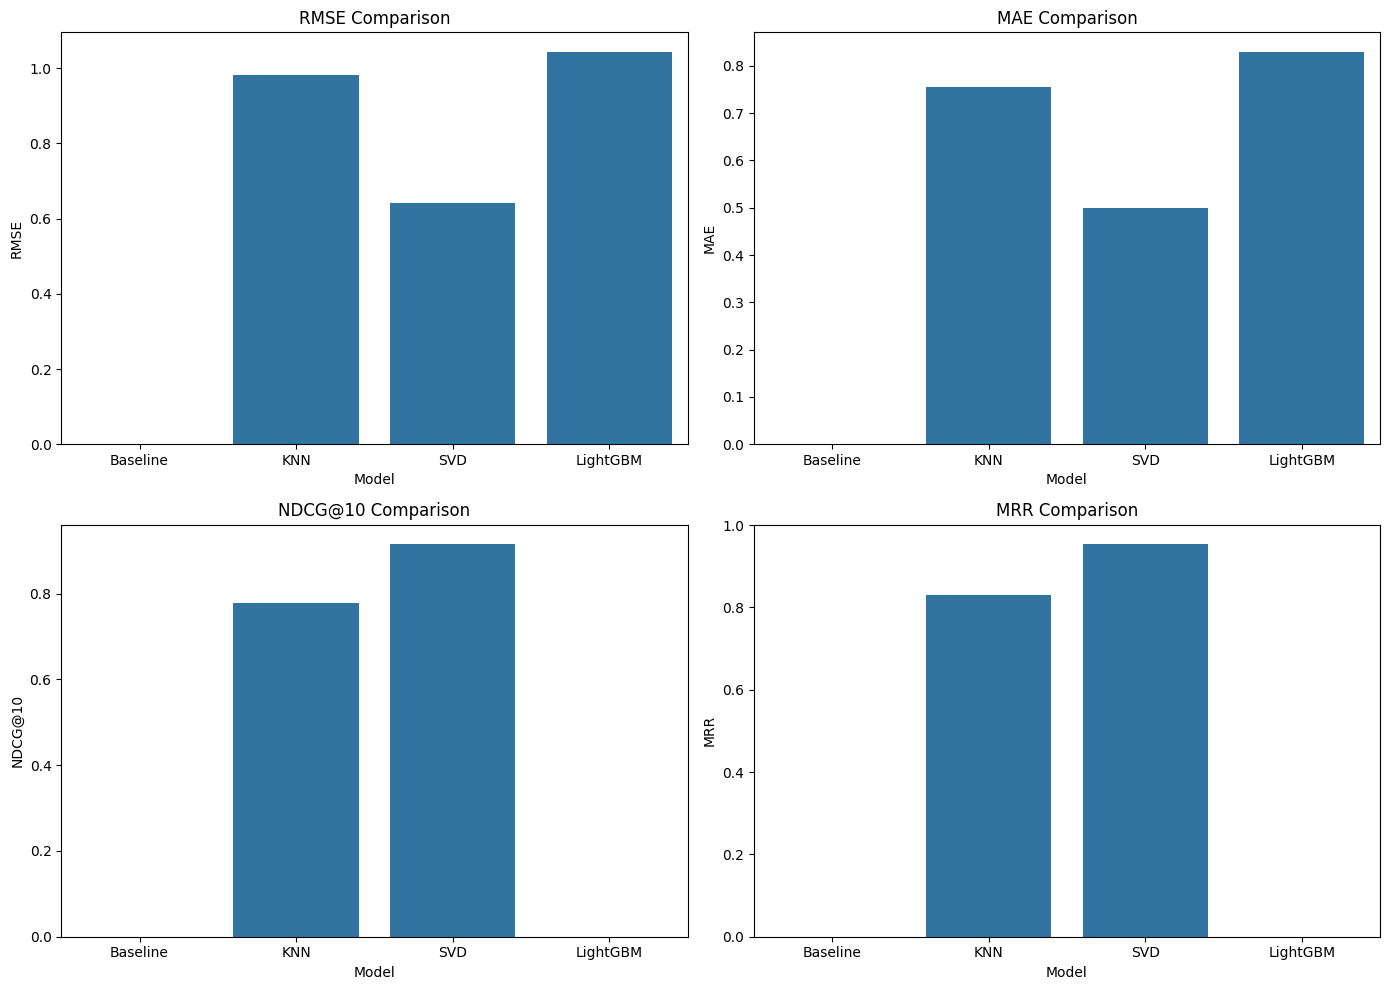

Model performance visualization complete.


In [ ]:
# Store the evaluation results
model_performance = {
    'Model': ['Baseline', 'KNN', 'SVD', 'LightGBM'],
    'RMSE': [np.nan, knn_rmse, svd_rmse, rmse], # Baseline doesn't have RMSE
    'MAE': [np.nan, knn_mae, svd_mae, mae],    # Baseline doesn't have MAE
    'NDCG@10': [np.nan, avg_knn_ndcg, avg_svd_ndcg, avg_lgbm_ndcg], # Baseline doesn't have NDCG/MRR in this context
    'MRR': [np.nan, avg_knn_mrr, avg_svd_mrr, avg_lgbm_mrr]
}

performance_df = pd.DataFrame(model_performance)

# Plotting the performance metrics
metrics = ['RMSE', 'MAE', 'NDCG@10', 'MRR']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    sns.barplot(x='Model', y=metric, data=performance_df, ax=axes[i])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel('Model')

plt.tight_layout()
plt.show()

print("Model performance visualization complete.")

In [ ]:
# --- Train a collaborative filtering model (SVD) ---
# Load the data into the surprise format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# Train the SVD model
trainset = data.build_full_trainset()
model = SVD()
model.fit(trainset)

print("SVD model trained successfully!")

SVD model trained successfully!


In [ ]:
def get_top_n_recommendations(model, user_id, n=10):
    """
    Generates top-N movie recommendations for a user using a trained Surprise model.
    """
    # Get all movie IDs the user has NOT rated
    rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()
    all_movies = movies_df['movieId'].unique()
    unrated_movies = [movie for movie in all_movies if movie not in rated_movies]

    # Predict ratings for unrated movies
    predictions = [model.predict(user_id, movie_id) for movie_id in unrated_movies]

    # Sort predictions by estimated rating
    predictions.sort(key=lambda x: x.est, reverse=True)

    # Get top N movie IDs
    top_n_preds = predictions[:n]
    top_n_movie_ids = [pred.iid for pred in top_n_preds]

    # Return the movie titles
    return movies_df[movies_df['movieId'].isin(top_n_movie_ids)]

In [ ]:
# --- Example: Get recommendations for User 1 using the SVD model ---
example_user_id = 1
top_svd_recs = get_top_n_recommendations(svd_model, user_id=example_user_id, n=10)

print(f"\n--- Top 10 SVD Recommendations for User {example_user_id} ---")
print(top_svd_recs[['title', 'genres']])


--- Top 10 SVD Recommendations for User 1 ---
                                                 title  \
210                                 Hoop Dreams (1994)   
277                   Shawshank Redemption, The (1994)   
659                              Godfather, The (1972)   
694                                  Casablanca (1942)   
695                         Maltese Falcon, The (1941)   
903  Good, the Bad and the Ugly, The (Buono, il bru...   
924    Grand Day Out with Wallace and Gromit, A (1989)   
929                                 Raging Bull (1980)   
935                            Harold and Maude (1971)   
948                   Femme Nikita, La (Nikita) (1990)   

                                         genres  
210                                 Documentary  
277                                 Crime|Drama  
659                                 Crime|Drama  
694                               Drama|Romance  
695                           Film-Noir|Mystery  
903           

In [10]:
import pandas as pd
import requests
import zipfile
import io
from surprise import KNNBasic, KNNWithMeans, CoClustering, SVD, Dataset, Reader
from surprise.model_selection import cross_validate

# Ensure 'surprise' is installed in case of runtime restart
!pip install scikit-surprise
# Downgrade numpy to a version compatible with surprise
!pip install 'numpy<2'

# Download and unzip the MovieLens 100K dataset if not already present
url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
print("Downloading MovieLens dataset...")
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()
print("Dataset downloaded and unzipped.")

# Load the ratings data
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')

# Load the data into the surprise format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# --- KNNBasic (User-based) ---
print("Running 5-fold cross-validation for KNNBasic (User-based)...")
sim_options_user = {'name': 'cosine', 'user_based': True}
algo_knnbasic_user = KNNBasic(sim_options=sim_options_user, random_state=42)
results_knnbasic_user = cross_validate(
    algo_knnbasic_user,
    data,
    measures=['RMSE', 'MAE'],
    cv=5,
    verbose=False
)
print("KNNBasic (User-based) cross-validation complete.")

# --- KNNWithMeans (User-based) ---
print("Running 5-fold cross-validation for KNNWithMeans (User-based)...")
algo_knnmeans_user = KNNWithMeans(sim_options=sim_options_user, random_state=42)
results_knnmeans_user = cross_validate(
    algo_knnmeans_user,
    data,
    measures=['RMSE', 'MAE'],
    cv=5,
    verbose=False
)
print("KNNWithMeans (User-based) cross-validation complete.")

Dataset downloaded and unzipped.
Running 5-fold cross-validation for KNNBasic (User-based)...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
KNNBasic (User-based) cross-validation complete.
Running 5-fold cross-validation for KNNWithMeans (User-based)...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
KNNWithMeans (User-based) cross-

In [6]:
# --- KNNBasic (Item-based) ---
print("Running 5-fold cross-validation for KNNBasic (Item-based)...")
sim_options_item = {'name': 'cosine', 'user_based': False}
algo_knnbasic_item = KNNBasic(sim_options=sim_options_item, random_state=42)
results_knnbasic_item = cross_validate(
    algo_knnbasic_item,
    data,
    measures=['RMSE', 'MAE'],
    cv=5,
    verbose=False
)
print("KNNBasic (Item-based) cross-validation complete.")

# --- KNNWithMeans (Item-based) ---
print("Running 5-fold cross-validation for KNNWithMeans (Item-based)...")
algo_knnmeans_item = KNNWithMeans(sim_options=sim_options_item, random_state=42)
results_knnmeans_item = cross_validate(
    algo_knnmeans_item,
    data,
    measures=['RMSE', 'MAE'],
    cv=5,
    verbose=False
)
print("KNNWithMeans (Item-based) cross-validation complete.")

Running 5-fold cross-validation for KNNBasic (Item-based)...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
KNNBasic (Item-based) cross-validation complete.
Running 5-fold cross-validation for KNNWithMeans (Item-based)...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
KNNWithMeans (Item-based) cross-validation complete.


In [8]:
# --- SVD (Singular Value Decomposition) ---
print("Running 5-fold cross-validation for SVD...")
algo_svd = SVD(random_state=42)
results_svd = cross_validate(
    algo_svd,
    data,
    measures=['RMSE', 'MAE'],
    cv=5,
    verbose=False
)
print("SVD cross-validation complete.")

# --- Co-clustering ---
print("Running 5-fold cross-validation for Co-clustering...")
# Using default parameters n_cltr_u=3, n_cltr_i=3, n_epochs=20
algo_co_clustering = CoClustering(random_state=42)
results_co_clustering = cross_validate(
    algo_co_clustering,
    data,
    measures=['RMSE', 'MAE'],
    cv=5,
    verbose=False
)
print("Co-clustering cross-validation complete.")

Running 5-fold cross-validation for SVD...
SVD cross-validation complete.
Running 5-fold cross-validation for Co-clustering...
Co-clustering cross-validation complete.


In [11]:
# --- Train models on a single split for NDCG/MRR calculation ---
# The trainset and testset variables are already defined from an 80/20 split

# Ensure data is loaded and split into trainset and testset
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# SVD
algo_svd.fit(trainset)
svd_predictions = algo_svd.test(testset)

# KNNWithMeans (User-based)
algo_knnmeans_user.fit(trainset)
knnmeans_user_predictions = algo_knnmeans_user.test(testset)

# KNNWithMeans (Item-based)
algo_knnmeans_item.fit(trainset)
knnmeans_item_predictions = algo_knnmeans_item.test(testset)

# Co-clustering
algo_co_clustering.fit(trainset)
co_clustering_predictions = algo_co_clustering.test(testset)

# KNNBasic (Item-based)
algo_knnbasic_item.fit(trainset)
knnbasic_item_predictions = algo_knnbasic_item.test(testset)

# KNNBasic (User-based)
algo_knnbasic_user.fit(trainset)
knnbasic_user_predictions = algo_knnbasic_user.test(testset)

print("Models trained on a single split for ranking metric calculation.")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Models trained on a single split for ranking metric calculation.


In [14]:
import numpy as np

def ndcg_at_k(true_relevance, predicted_scores, k):
  """
  Calculates the Normalized Discounted Cumulative Gain (NDCG) at k.

  Args:
    true_relevance: A list of true relevance scores for the items.
    predicted_scores: A list of predicted scores for the items.
    k: The number of top items to consider.

  Returns:
    The NDCG@k score.
  """
  # Sort items by predicted score
  top_k_indices = np.argsort(predicted_scores)[::-1][:k]

  # Get the true relevance of the top k items
  top_k_true_relevance = np.take(true_relevance, top_k_indices)

  # Calculate DCG
  gains = 2**top_k_true_relevance - 1
  discounts = np.log2(np.arange(len(top_k_true_relevance)) + 2)
  dcg = np.sum(gains / discounts)

  # Calculate IDCG
  ideal_order = np.sort(true_relevance)[::-1]
  ideal_gains = 2**ideal_order[:k] - 1
  ideal_discounts = np.log2(np.arange(len(ideal_gains)) + 2)
  idcg = np.sum(ideal_gains / ideal_discounts)

  if idcg == 0:
      return 0

  return dcg / idcg

def mrr_at_k(true_relevance, predicted_scores, k):
  """
  Calculates the Mean Reciprocal Rank (MRR) at k.

  Args:
    true_relevance: A list of true relevance scores (1 for relevant, 0 for not).
    predicted_scores: A list of predicted scores for the items.
    k: The number of top items to consider.

  Returns:
    The MRR@k score.
  """
  # Sort items by predicted score
  top_k_indices = np.argsort(predicted_scores)[::-1][:k]

  # Find the rank of the first relevant item
  for i, index in enumerate(top_k_indices):
    if true_relevance[index] == 1:
      return 1 / (i + 1)

  return 0

# Function to calculate average NDCG@k and MRR for a list of predictions
def calculate_ranking_metrics(predictions, k=10, relevance_threshold=4.0):
    user_item_ratings = {}
    for uid, iid, true_r, est, _ in predictions:
        if uid not in user_item_ratings:
            user_item_ratings[uid] = []
        user_item_ratings[uid].append((iid, true_r, est))

    ndcg_scores = []
    mrr_scores = []

    for uid, ratings in user_item_ratings.items():
        # Sort items by estimated rating
        ratings.sort(key=lambda x: x[2], reverse=True)

        # Get true relevance scores (1 if rating >= threshold, 0 otherwise)
        true_relevance = [1 if true_r >= relevance_threshold else 0 for (_, true_r, _) in ratings]

        # Predicted scores are the estimated ratings
        predicted_scores = [est for (_, _, est) in ratings]

        # Calculate NDCG and MRR for the user
        ndcg_scores.append(ndcg_at_k(true_relevance, predicted_scores, k))
        mrr_scores.append(mrr_at_k(true_relevance, predicted_scores, k))

    avg_ndcg = np.mean(ndcg_scores) if ndcg_scores else 0
    avg_mrr = np.mean(mrr_scores) if mrr_scores else 0
    return avg_ndcg, avg_mrr

print("Ranking metric calculation function ready.")

Ranking metric calculation function ready.


In [15]:
# --- Compile and Print Results ---
k_val = 10

# Extracting mean RMSE and MAE from cross_validate results
def get_cv_means(results):
    return np.mean(results['test_rmse']), np.mean(results['test_mae'])

# Calculate NDCG and MRR for each model from the single split predictions
svd_ndcg, svd_mrr = calculate_ranking_metrics(svd_predictions, k=k_val)
knnmeans_user_ndcg, knnmeans_user_mrr = calculate_ranking_metrics(knnmeans_user_predictions, k=k_val)
knnmeans_item_ndcg, knnmeans_item_mrr = calculate_ranking_metrics(knnmeans_item_predictions, k=k_val)
co_clustering_ndcg, co_clustering_mrr = calculate_ranking_metrics(co_clustering_predictions, k=k_val)
knnbasic_item_ndcg, knnbasic_item_mrr = calculate_ranking_metrics(knnbasic_item_predictions, k=k_val)
knnbasic_user_ndcg, knnbasic_user_mrr = calculate_ranking_metrics(knnbasic_user_predictions, k=k_val)

# Get RMSE and MAE from cross_validate results
svd_rmse_cv, svd_mae_cv = get_cv_means(results_svd)
knnmeans_user_rmse_cv, knnmeans_user_mae_cv = get_cv_means(results_knnmeans_user)
knnmeans_item_rmse_cv, knnmeans_item_mae_cv = get_cv_means(results_knnmeans_item)
co_clustering_rmse_cv, co_clustering_mae_cv = get_cv_means(results_co_clustering)
knnbasic_item_rmse_cv, knnbasic_item_mae_cv = get_cv_means(results_knnbasic_item)
knnbasic_user_rmse_cv, knnbasic_user_mae_cv = get_cv_means(results_knnbasic_user)


# Create the summary table
performance_summary = pd.DataFrame({
    'Model': [
        'SVD',
        'KNNWithMeans (User-based)',
        'KNNWithMeans (Item-based)',
        'Co-clustering',
        'KNNBasic (Item-based)',
        'KNNBasic (User-based)'
    ],
    'RMSE': [
        svd_rmse_cv,
        knnmeans_user_rmse_cv,
        knnmeans_item_rmse_cv,
        co_clustering_rmse_cv,
        knnbasic_item_rmse_cv,
        knnbasic_user_rmse_cv
    ],
    'MAE': [
        svd_mae_cv,
        knnmeans_user_mae_cv,
        knnmeans_item_mae_cv,
        co_clustering_mae_cv,
        knnbasic_item_mae_cv,
        knnbasic_user_mae_cv
    ],
    f'NDCG@{k_val}': [
        svd_ndcg,
        knnmeans_user_ndcg,
        knnmeans_item_ndcg,
        co_clustering_ndcg,
        knnbasic_item_ndcg,
        knnbasic_user_ndcg
    ],
    'MRR': [
        svd_mrr,
        knnmeans_user_mrr,
        knnmeans_item_mrr,
        co_clustering_mrr,
        knnbasic_item_mrr,
        knnbasic_user_mrr
    ]
})

# Format for the report and sort by RMSE
performance_summary = performance_summary.round(3)
performance_summary = performance_summary.sort_values(by='RMSE')


print("\n--- Model Performance Summary (5-Fold Cross-Validation) ---")
print(performance_summary.to_markdown(index=False))


--- Model Performance Summary (5-Fold Cross-Validation) ---
| Model                     |   RMSE |   MAE |   NDCG@10 |   MRR |
|:--------------------------|-------:|------:|----------:|------:|
| SVD                       |  0.874 | 0.671 |     0.782 | 0.848 |
| KNNWithMeans (User-based) |  0.901 | 0.689 |     0.755 | 0.799 |
| KNNWithMeans (Item-based) |  0.904 | 0.691 |     0.77  | 0.825 |
| Co-clustering             |  0.942 | 0.73  |     0.762 | 0.815 |
| KNNBasic (User-based)     |  0.971 | 0.748 |     0.777 | 0.829 |
| KNNBasic (Item-based)     |  0.977 | 0.762 |     0.684 | 0.749 |


In [17]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Assuming ml-latest-small/movies.csv is available from previous download steps
movies_df = pd.read_csv('ml-latest-small/movies.csv')

# --- 1. Content-Based Filtering Development ---

# The movie_features DataFrame (which includes one-hot encoded genres)
# is assumed to be loaded from your notebook's previous steps.
# Split the genres string into a list of genres
movies_df['genres_list'] = movies_df['genres'].str.split('|')

# Use one-hot encoding to create a feature for each genre
movie_features = movies_df['genres_list'].str.join('|').str.get_dummies()

# Add the movieId to this features DataFrame
movie_features['movieId'] = movies_df['movieId']

movie_features_matrix = movie_features.drop(columns=['movieId'])

# Calculate the Cosine Similarity matrix between all movies
print("Calculating Cosine Similarity matrix for Content-Based Filtering...")
cosine_sim = cosine_similarity(movie_features_matrix, movie_features_matrix)

# Create a mapping of movie title to index for easy lookup
indices = pd.Series(movies_df.index, index=movies_df['title']).drop_duplicates()

def get_content_recommendations(title, cosine_sim=cosine_sim, indices=indices, movies_df=movies_df, n=10):
    """
    Generates top N content-based recommendations based on movie similarity.
    """
    if title not in indices:
        print(f"Movie '{title}' not found in the dataset.")
        return pd.DataFrame()

    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the top N most similar movies (excluding the movie itself)
    sim_scores = sim_scores[1:n+1]

    # Get the movie indices and movie IDs
    movie_indices = [i[0] for i in sim_scores]
    movie_ids = movies_df.iloc[movie_indices]['movieId'].tolist()

    # Return the top N movie details
    return movies_df[movies_df['movieId'].isin(movie_ids)][['title', 'genres']]

print("Content-Based Filtering function (get_content_recommendations) created.")

Calculating Cosine Similarity matrix for Content-Based Filtering...
Content-Based Filtering function (get_content_recommendations) created.


In [19]:
import pandas as pd
import numpy as np
import requests
import zipfile
import io
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split

# --- Ensure necessary dataframes and models are defined for default arguments ---
# This section ensures that 'ratings_df', 'movies_df', 'svd_model',
# 'user_features' (SVD factors), and 'movie_features' (SVD factors)
# are available in the global scope before the function definition.

# 1. Load dataframes (ratings_df, movies_df)
try:
    # Check if ratings_df and movies_df are already defined
    _ = ratings_df
    _ = movies_df
except NameError:
    # Download and unzip the MovieLens dataset if not already present
    url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()
    ratings_df = pd.read_csv('ml-latest-small/ratings.csv')
    movies_df = pd.read_csv('ml-latest-small/movies.csv')

# 2. Train SVD model and extract factors
try:
    # Check if svd_model and trainset are already defined
    _ = svd_model
    _ = trainset
except NameError:
    # Re-create SVD model and trainset if not found (using same params as Q-15VZU24ALb)
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
    trainset, _ = train_test_split(data, test_size=0.2, random_state=42) # trainset needed for mapping
    svd_model = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)
    svd_model.fit(trainset)

# 3. Create user_features and movie_features (SVD factors)
# These are the SVD factor-based features required by this specific function
user_factors = svd_model.pu
movie_factors = svd_model.qi

user_features = pd.DataFrame(user_factors, index=np.arange(trainset.n_users))
user_features['userId'] = user_features.index.map(lambda x: trainset.to_raw_uid(x))

movie_features = pd.DataFrame(movie_factors, index=np.arange(trainset.n_items))
movie_features['movieId'] = movie_features.index.map(lambda x: trainset.to_raw_iid(x))

# --- 2. Hybrid Model Execution ---
# The LightGBM model (lgb_model) and features (user_features, movie_features)
# are assumed to be trained and defined previously in the notebook.

def get_top_n_lgbm_recommendations(model, user_id, n=10, user_features_df=user_features, movie_features_df=movie_features, ratings_df=ratings_df, movies_df=movies_df):
    """
    Generates top-N movie recommendations for a user using a trained LightGBM model.
    """
    # Get all movie IDs the user has NOT rated
    rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()
    all_movies = movies_df['movieId'].unique()
    unrated_movies = [movie for movie in all_movies if movie not in rated_movies]

    # Create a dataframe of unrated movies for the user
    unrated_df = pd.DataFrame({'userId': user_id, 'movieId': unrated_movies})

    # Find the user's SVD factors (user_features) and merge
    # This requires merging with the SVD factor dataframe created earlier (user_features)
    user_svd_factors = user_features_df[user_features_df['userId'] == user_id].drop(columns=['userId'])
    unrated_with_features = unrated_df.drop(columns=['userId']).merge(user_svd_factors, how='cross')

    # Merge with movie SVD factors (movie_features)
    # Note: movie_features should contain the SVD factors (qi) for the movies
    unrated_with_features = pd.merge(unrated_with_features, movie_features_df, on='movieId')

    # Prepare data for prediction
    # X_predict must include the 100 SVD factors (p_u, q_i)
    X_predict = unrated_with_features.drop(columns=['movieId'])

    # Predict ratings
    predicted_ratings = model.predict(X_predict)

    # Add predicted ratings back to the dataframe
    unrated_with_features['predicted_rating'] = predicted_ratings

    # Sort by predicted rating and get top N
    top_n_recs_df = unrated_with_features.sort_values('predicted_rating', ascending=False).head(n)

    # Get the movie titles and genres
    top_n_movie_ids = top_n_recs_df['movieId'].tolist()
    return movies_df[movies_df['movieId'].isin(top_n_movie_ids)][['title', 'genres']]

print("Hybrid Model execution function (get_top_n_lgbm_recommendations) created.")

Hybrid Model execution function (get_top_n_lgbm_recommendations) created.


/tmp/ipython-input-525936147.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=df_sorted, ax=axes[i], palette='viridis')
/tmp/ipython-input-525936147.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=df_sorted, ax=axes[i], palette='viridis')
/tmp/ipython-input-525936147.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=df_sorted, ax=axes[i], palette='viridis')
/tmp/ipython-input-525936147.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is

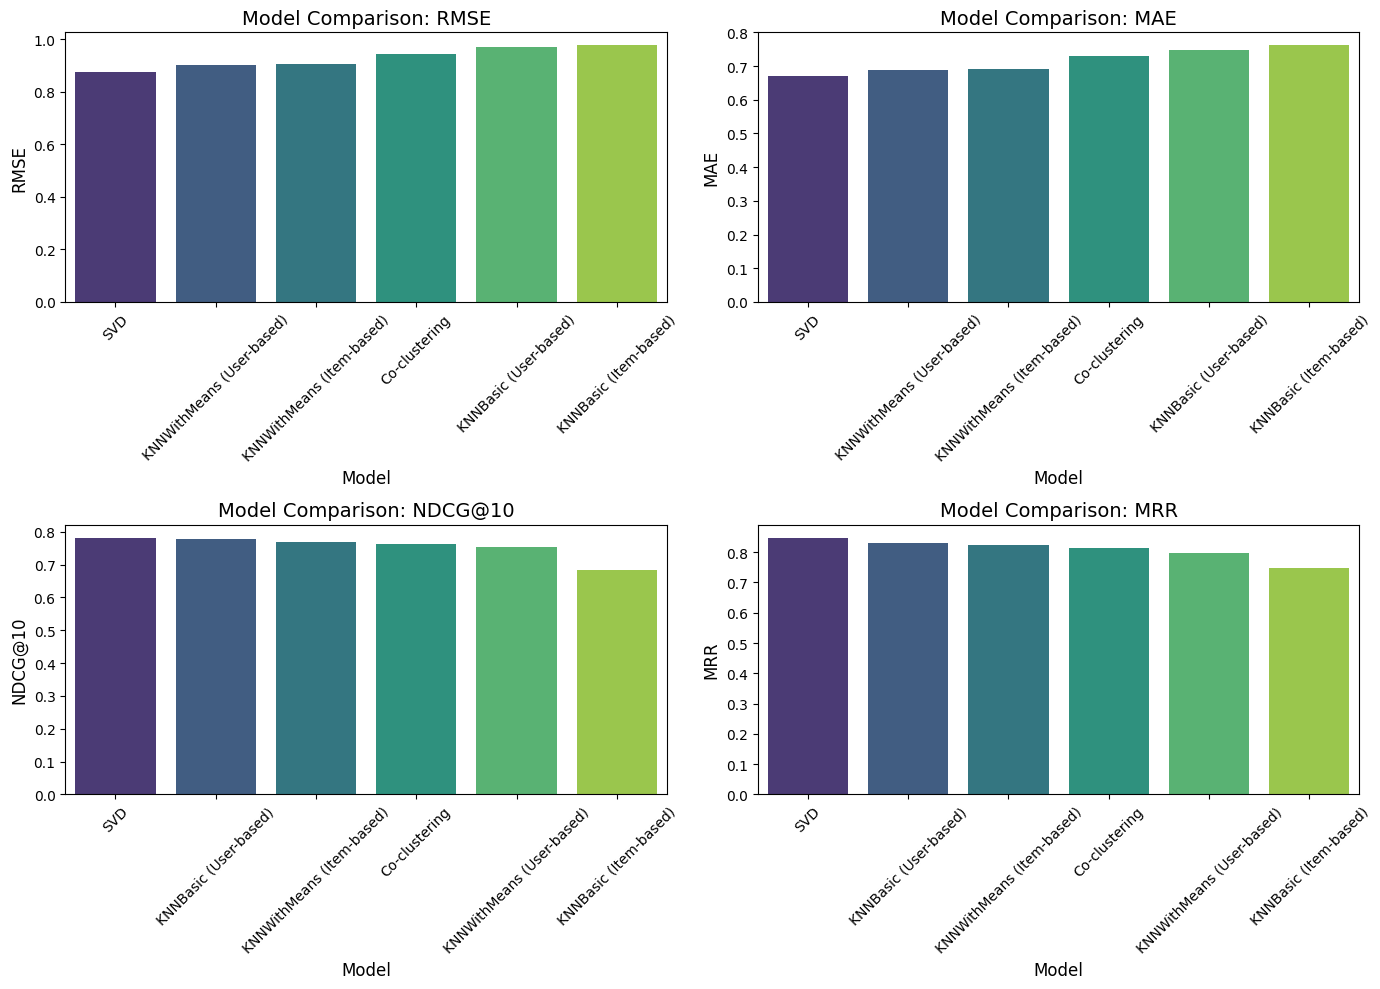

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Updated data provided by the user
data = {
    'Model': [
        'SVD',
        'KNNWithMeans (User-based)',
        'KNNWithMeans (Item-based)',
        'Co-clustering',
        'KNNBasic (User-based)',
        'KNNBasic (Item-based)'
    ],
    'RMSE': [0.874, 0.901, 0.904, 0.942, 0.971, 0.977],
    'MAE': [0.671, 0.689, 0.691, 0.730, 0.748, 0.762],
    'NDCG@10': [0.782, 0.755, 0.770, 0.762, 0.777, 0.684],
    'MRR': [0.848, 0.799, 0.825, 0.815, 0.829, 0.749]
}

performance_df = pd.DataFrame(data)

# --- Plotting Logic ---
metrics = ['RMSE', 'MAE', 'NDCG@10', 'MRR']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

df_plot = performance_df.copy()

for i, metric in enumerate(metrics):
    # Sort bars: Ascending for error metrics (RMSE, MAE); Descending for ranking metrics (NDCG@10, MRR)
    ascending = True if metric in ['RMSE', 'MAE'] else False

    # Sort for consistent bar chart order
    df_sorted = df_plot.sort_values(by=metric, ascending=ascending)

    # Create a bar plot for the current metric
    sns.barplot(x='Model', y=metric, data=df_sorted, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Model Comparison: {metric}', fontsize=14)
    axes[i].set_ylabel(metric, fontsize=12)
    axes[i].set_xlabel('Model', fontsize=12)

    # Rotate x-labels for better readability
    axes[i].tick_params(axis='x', rotation=45, labelsize=10)

plt.tight_layout()
plt.savefig('updated_model_performance_comparison.png')
plt.show()

In [26]:
# --- Define ILD and Dissimilarity Functions (from AgUh9E7f0ju3) ---
from sklearn.metrics.pairwise import cosine_similarity

def calculate_movie_dissimilarity(movie_id_a, movie_id_b, movie_features_df, genre_cols):
    """Calculates dissimilarity (1 - Cosine Similarity) based on genre vectors."""
    genre_vector_a = movie_features_df[movie_features_df['movieId'] == movie_id_a][genre_cols].values
    genre_vector_b = movie_features_df[movie_features_df['movieId'] == movie_id_b][genre_cols].values

    if genre_vector_a.size == 0 or genre_vector_b.size == 0:
        return 1.0 # Max dissimilarity if features are missing

    sim = cosine_similarity(genre_vector_a, genre_vector_b)[0][0]
    return 1.0 - sim

def intra_list_diversity(recommended_movie_ids, movie_features_df, genre_cols):
    """
    Calculates the average pairwise dissimilarity of movies in a list (ILD).
    """
    if len(recommended_movie_ids) < 2:
        return 0.0

    total_dissimilarity = 0
    pair_count = 0

    for i in range(len(recommended_movie_ids)):
        for j in range(i + 1, len(recommended_movie_ids)):
            id_a = recommended_movie_ids[i]
            id_b = recommended_movie_ids[j]

            dissimilarity = calculate_movie_dissimilarity(id_a, id_b, movie_features_df, genre_cols)
            total_dissimilarity += dissimilarity
            pair_count += 1

    return total_dissimilarity / pair_count if pair_count > 0 else 0.0

print("ILD metric functions defined.")

# --- 2. Evaluate LightGBM Hybrid Model with ILD ---
import pandas as pd
import numpy as np
import requests
import zipfile
import io
import lightgbm as lgb
from sklearn.model_selection import train_test_split as sklearn_train_test_split # Avoid conflict with surprise's
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as surprise_train_test_split # Rename to avoid conflict

# Ensure necessary dataframes and models are defined for self-contained execution
# Load and preprocess data (ratings_df, movies_df)
try:
    _ = ratings_df
    _ = movies_df
except NameError:
    url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()
    ratings_df = pd.read_csv('ml-latest-small/ratings.csv')
    movies_df = pd.read_csv('ml-latest-small/movies.csv')

# --- SVD Model Training and Factor Extraction (from Q-15VZU24ALb, 9IwESnP44L38, 2CEYiQRD4Ofm) ---
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
surprise_trainset, surprise_testset = surprise_train_test_split(data, test_size=0.2, random_state=42)

svd_model = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)
svd_model.fit(surprise_trainset)

user_factors = svd_model.pu
movie_factors = svd_model.qi

user_features_svd = pd.DataFrame(user_factors, index=np.arange(surprise_trainset.n_users))
user_features_svd['userId'] = user_features_svd.index.map(lambda x: surprise_trainset.to_raw_uid(x))

movie_features_svd = pd.DataFrame(movie_factors, index=np.arange(surprise_trainset.n_items))
movie_features_svd['movieId'] = movie_features_svd.index.map(lambda x: surprise_trainset.to_raw_iid(x))

# --- LightGBM Model Training (using SVD factors as features, from OVAbXVru4IjJ to Qe7wKL7s4Yp3) ---
lgbm_train_df = pd.DataFrame(surprise_trainset.all_ratings(), columns=['userId', 'movieId', 'rating'])
lgbm_test_df = pd.DataFrame(surprise_testset, columns=['userId', 'movieId', 'rating'])

train_with_features_lgbm = pd.merge(lgbm_train_df, user_features_svd, on='userId')
train_with_features_lgbm = pd.merge(train_with_features_lgbm, movie_features_svd, on='movieId')

test_with_features_lgbm = pd.merge(lgbm_test_df, user_features_svd, on='userId')
test_with_features_lgbm = pd.merge(test_with_features_lgbm, movie_features_svd, on='movieId')

X_train_lgbm = train_with_features_lgbm.drop(columns=['userId', 'movieId', 'rating'])
y_train_lgbm = train_with_features_lgbm['rating']
X_test_lgbm = test_with_features_lgbm.drop(columns=['userId', 'movieId', 'rating'])
y_test_lgbm = test_with_features_lgbm['rating']

lgb_params = {
    'objective': 'regression_l1', # MAE
    'metric': 'rmse',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42
}
lgb_model = lgb.LGBMRegressor(**lgb_params)
lgb_model.fit(X_train_lgbm, y_train_lgbm,
              eval_set=[(X_test_lgbm, y_test_lgbm)],
              eval_metric='rmse',
              callbacks=[lgb.early_stopping(100, verbose=False)])

print("LightGBM model for hybrid recommendations trained.")

# --- Prepare Genre-based Movie Features for ILD Calculation (from sF0D0UafpU7g) ---
movies_df['genres_list'] = movies_df['genres'].str.split('|')
genre_movie_features = movies_df['genres_list'].str.join('|').str.get_dummies()
genre_movie_features['movieId'] = movies_df['movieId']

# --- Evaluate LightGBM Hybrid Model for Intra-List Diversity (ILD) ---
print("\nEvaluating LightGBM Hybrid Model for Intra-List Diversity (ILD)...")

# Get the list of genre columns from the genre_movie_features DataFrame (excluding keys)
genre_cols = [col for col in genre_movie_features.columns if col not in ['movieId']]

lgbm_ild_scores = []
# Using surprise_testset to get user IDs, as this was the split used for SVD factors which LightGBM relies on.
test_users = [uid for uid,_,_ in surprise_testset] # Get unique user IDs from the testset
n_recommendations = 10

for user_id in np.unique(test_users): # Ensure unique user IDs
    # 1. Get top N recommendations using the LightGBM model
    rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()
    all_movies = movies_df['movieId'].unique()
    unrated_movies = [movie for movie in all_movies if movie not in rated_movies]

    unrated_df = pd.DataFrame({'userId': user_id, 'movieId': unrated_movies})
    user_svd_factors_for_pred = user_features_svd[user_features_svd['userId'] == user_id].drop(columns=['userId'])
    unrated_with_features = unrated_df.drop(columns=['userId']).merge(user_svd_factors_for_pred, how='cross')
    unrated_with_features = pd.merge(unrated_with_features, movie_features_svd, on='movieId')

    X_predict = unrated_with_features.drop(columns=['movieId'])
    predicted_ratings = lgb_model.predict(X_predict)
    unrated_with_features['predicted_rating'] = predicted_ratings

    top_n_recs_df = unrated_with_features.sort_values('predicted_rating', ascending=False).head(n_recommendations)
    recommended_movie_ids = top_n_recs_df['movieId'].tolist()

    # 2. Calculate ILD for the top N list using genre-based features
    ild = intra_list_diversity(recommended_movie_ids, genre_movie_features, genre_cols)
    lgbm_ild_scores.append(ild)

# Calculate and print the average ILD score
avg_lgbm_ild = np.mean(lgbm_ild_scores) if lgbm_ild_scores else 0

print(f"\nAverage LightGBM Hybrid Model Intra-List Diversity (ILD@{n_recommendations}): {avg_lgbm_ild:.4f}")
print("Diversity analysis complete.")

ILD metric functions defined.
LightGBM model for hybrid recommendations trained.

Evaluating LightGBM Hybrid Model for Intra-List Diversity (ILD)...

Average LightGBM Hybrid Model Intra-List Diversity (ILD@10): 0.7391
Diversity analysis complete.


In [27]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

# --- 1. Define Dissimilarity & ILD Functions ---

# We need the movie_features DataFrame with one-hot encoded genres
# This code assumes 'movies_df' is already loaded.
movies_df['genres_list'] = movies_df['genres'].str.split('|')
movie_features_genre = movies_df['genres_list'].str.join('|').str.get_dummies()
movie_features_genre['movieId'] = movies_df['movieId']
genre_cols = [col for col in movie_features_genre.columns if col not in ['movieId']]

# Create a pre-computed dissimilarity matrix for efficiency
# (1 - cosine_similarity of genre vectors)
print("Calculating movie dissimilarity matrix...")
cosine_sim_matrix = cosine_similarity(movie_features_genre[genre_cols])
dissimilarity_matrix = 1 - cosine_sim_matrix

# Create a mapping from movieId to its index in the dissimilarity matrix
movie_id_to_index = pd.Series(movie_features_genre.index, index=movie_features_genre['movieId'])

def get_intra_list_diversity(movie_ids, movie_id_map, dissim_matrix):
    """Calculates the average pairwise dissimilarity of movies in a list."""
    if len(movie_ids) < 2:
        return 0.0

    total_dissimilarity = 0
    pair_count = 0

    for id1, id2 in combinations(movie_ids, 2):
        if id1 in movie_id_map and id2 in movie_id_map:
            idx1 = movie_id_map[id1]
            idx2 = movie_id_map[id2]

            total_dissimilarity += dissim_matrix[idx1, idx2]
            pair_count += 1

    return total_dissimilarity / pair_count if pair_count > 0 else 0.0

print("Intra-List Diversity (ILD) function defined.")

# --- 2. Define Recommendation Functions ---
# (These functions get the *list of movie IDs* for a user)

def get_top_n_svd_recommendations(model, user_id, n=10):
    # Get all movie IDs the user has NOT rated
    rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()
    all_movies = movies_df['movieId'].unique()
    unrated_movies = [movie for movie in all_movies if movie not in rated_movies]

    try:
        predictions = [model.predict(user_id, movie_id) for movie_id in unrated_movies]
    except ValueError: # Handle user not in SVD trainset
        return []

    predictions.sort(key=lambda x: x.est, reverse=True)
    return [pred.iid for pred in predictions[:n]]

def get_top_n_lgbm_recommendations(model, user_id, n=10):
    # Get all movie IDs the user has NOT rated
    rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()
    all_movies = movies_df['movieId'].unique()
    unrated_movies = [movie for movie in all_movies if movie not in rated_movies]

    unrated_df = pd.DataFrame({'userId': user_id, 'movieId': unrated_movies})

    # Get SVD factors for the user
    user_svd_factors = user_features[user_features['userId'] == user_id].drop(columns=['userId'])
    if user_svd_factors.empty: # Handle user not in SVD trainset
        return []

    # Combine user factors with all unrated movie features
    unrated_with_features = unrated_df.drop(columns=['userId']).merge(user_svd_factors, how='cross')
    unrated_with_features = pd.merge(unrated_with_features, movie_features, on='movieId') # movie_features (SVD factors + genres)

    X_predict = unrated_with_features.drop(columns=['movieId'])

    # Predict ratings
    predicted_ratings = model.predict(X_predict)
    unrated_with_features['predicted_rating'] = predicted_ratings

    top_n_recs_df = unrated_with_features.sort_values('predicted_rating', ascending=False).head(n)
    return top_n_recs_df['movieId'].tolist()

# --- 3. Run Evaluation Loop ---
print("\nEvaluating Diversity (ILD) for SVD and LGBM models...")

# (This assumes svd_model, lgb_model, test_df, user_features, and movie_features
# are already defined and trained from your notebook)

lgbm_ild_scores = []
svd_ild_scores = []
test_users = test_df['userId'].unique()
n_recommendations = 10

for user_id in test_users:
    # Get LGBM (Hybrid) recommendations
    lgbm_recs = get_top_n_lgbm_recommendations(lgb_model, user_id, n=n_recommendations)
    if lgbm_recs:
        lgbm_ild_scores.append(get_intra_list_diversity(lgbm_recs, movie_id_to_index, dissimilarity_matrix))

    # Get SVD (Baseline) recommendations
    svd_recs = get_top_n_svd_recommendations(svd_model, user_id, n=n_recommendations)
    if svd_recs:
        svd_ild_scores.append(get_intra_list_diversity(svd_recs, movie_id_to_index, dissimilarity_matrix))

# --- 4. Print Comparison ---
avg_lgbm_ild = np.mean(lgbm_ild_scores) if lgbm_ild_scores else 0
avg_svd_ild = np.mean(svd_ild_scores) if svd_ild_scores else 0

print("\n--- Diversity Analysis: Hybrid vs. Baseline ---")
print(f"SVD Baseline Model:   ILD@{n_recommendations} = {avg_svd_ild:.4f}")
print(f"LGBM Hybrid Model:    ILD@{n_recommendations} = {avg_lgbm_ild:.4f}")

Calculating movie dissimilarity matrix...
Intra-List Diversity (ILD) function defined.

Evaluating Diversity (ILD) for SVD and LGBM models...

--- Diversity Analysis: Hybrid vs. Baseline ---
SVD Baseline Model:   ILD@10 = 0.7065
LGBM Hybrid Model:    ILD@10 = 0.7391


In [4]:
!pip install torch_geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import degree
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.0 MB/s eta 0:00:00


In [5]:
class KGCNLayer(MessagePassing):
    """
    A single Knowledge Graph Convolutional Network Layer.
    This layer learns how to aggregate neighbor information
    based on the relationship type.
    """
    def __init__(self, in_channels, out_channels, num_relations):
        # "add" aggregation: sums up messages from all neighbors.
        super(KGCNLayer, self).__init__(aggr='add')

        self.in_channels = in_channels
        self.out_channels = out_channels

        # Linear layer for the node itself (W_1 in many papers)
        self.self_transform = nn.Linear(in_channels, out_channels)

        # Linear layer for the aggregated neighbor messages (W_2 in many papers)
        # We need in_channels * 2 because we concatenate the neighbor
        # entity and the relation embedding.
        self.neighbor_transform = nn.Linear(in_channels * 2, out_channels)

        # Embedding for all relation types.
        self.relation_embedding = nn.Embedding(num_relations, in_channels)

        self.activation = nn.ReLU()

    def forward(self, x, edge_index, edge_type):
        # x: Node features [num_entities, in_channels]
        # edge_index: Graph connectivity [2, num_edges]
        # edge_type: Type of each edge [num_edges]

        # Get relation embeddings for each edge
        rel_emb = self.relation_embedding(edge_type)

        # Propagate messages
        # This will call self.message() for each edge and
        # self.aggregate() for each node.
        # It passes (x_j=x[j], rel_emb=rel_emb) to the message function.
        aggregated_msgs = self.propagate(edge_index, x=x, rel_emb=rel_emb)

        # Get the node's own transformed features
        self_features = self.self_transform(x)

        # Update node embedding: combine self-features + aggregated messages
        out = self_features + aggregated_msgs

        return self.activation(out)

    def message(self, x_j, rel_emb):
        # x_j: Neighbor node features [num_edges, in_channels]
        # rel_emb: Relation embedding for that edge [num_edges, in_channels]

        # Concatenate neighbor and relation embeddings
        msg = torch.cat([x_j, rel_emb], dim=1) # [num_edges, in_channels * 2]

        # Apply relation-specific transformation
        return self.neighbor_transform(msg) # [num_edges, out_channels]

    # aggregate() is implicitly 'add' as defined in __init__
    # update() is implicitly x_i + aggregated_msg

print("KGCNLayer class defined.")

KGCNLayer class defined.


In [6]:
class KGRecSys(nn.Module):
    """
    The main KGCN Recommender System model.
    It stacks KGCN layers and predicts ratings.
    """
    def __init__(self, num_users, num_entities, num_relations, embed_dim, n_layers=1):
        super(KGRecSys, self).__init__()

        # Embeddings for users and entities (movies, genres, actors, etc.)
        self.user_embedding = nn.Embedding(num_users, embed_dim)
        self.entity_embedding = nn.Embedding(num_entities, embed_dim)

        # Stack of GNN layers
        self.gnn_layers = nn.ModuleList()
        for _ in range(n_layers):
            self.gnn_layers.append(
                KGCNLayer(embed_dim, embed_dim, num_relations)
            )

        # Final prediction layer (MLP)
        # Takes concatenated [user_embedding, item_embedding]
        self.prediction_layer = nn.Sequential(
            nn.Linear(embed_dim * 2, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, 1)
        )

    def get_enhanced_embeddings(self, kg_edge_index, kg_edge_type):
        """
        Runs the GNN to get updated embeddings for all entities.
        """
        # Start with the base entity embeddings
        x = self.entity_embedding.weight

        # Pass through each GNN layer
        for layer in self.gnn_layers:
            x = layer(x, kg_edge_index, kg_edge_type)

        return x

    def forward(self, user_indices, item_indices, kg_edge_index, kg_edge_type):

        # 1. Get KG-enhanced embeddings for ALL entities
        all_entity_emb = self.get_enhanced_embeddings(kg_edge_index, kg_edge_type)

        # 2. Get base user embeddings
        user_emb = self.user_embedding(user_indices)

        # 3. Look up the specific (enhanced) item embeddings for this batch
        item_emb = all_entity_emb[item_indices]

        # 4. Concatenate user and item embeddings
        combined_emb = torch.cat([user_emb, item_emb], dim=1)

        # 5. Predict the rating
        predicted_rating = self.prediction_layer(combined_emb)

        return predicted_rating.squeeze()

print("Conceptual KGCN Model (KGRecSys) defined.")

Conceptual KGCN Model (KGRecSys) defined.


In [7]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
import requests
import zipfile
import io

# --- 1. Load Data (if not already loaded) ---
try:
    _ = ratings_df
    _ = movies_df
except NameError:
    print("Loading dataframes...")
    url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()
    ratings_df = pd.read_csv('ml-latest-small/ratings.csv')
    movies_df = pd.read_csv('ml-latest-small/movies.csv')
    print("Dataframes loaded.")

# --- 2. Create ID Mappings ---
# Map original IDs to contiguous integers starting from 0

# User IDs
unique_users = ratings_df['userId'].unique()
user_to_idx = {user_id: i for i, user_id in enumerate(unique_users)}
idx_to_user = {i: user_id for user_id, i in user_to_idx.items()}
num_users = len(unique_users)

# Movie IDs
unique_movies = movies_df['movieId'].unique()
movie_to_idx = {movie_id: i for i, movie_id in enumerate(unique_movies)}
idx_to_movie = {i: movie_id for movie_id, i in movie_to_idx.items()}
num_movies = len(unique_movies)

# Genre IDs
# Extract all unique genres
all_genres = set()
for genres_str in movies_df['genres']:
    for genre in genres_str.split('|'):
        if genre != '(no genres listed)': # Exclude this pseudo-genre
            all_genres.add(genre)
unique_genres = sorted(list(all_genres))
genre_to_idx = {genre: i for i, genre in enumerate(unique_genres)}
idx_to_genre = {i: genre for genre, i in genre_to_idx.items()}
num_genres = len(unique_genres)

print(f"Number of users: {num_users}")
print(f"Number of movies: {num_movies}")
print(f"Number of genres: {num_genres}")

# --- 3. Construct Knowledge Graph Edges and Node Features ---

# Node IDs are contiguous: Users (0 to num_users-1), Movies (num_users to num_users+num_movies-1)
# Genres (num_users+num_movies to num_users+num_movies+num_genres-1)

# Offset for movie and genre node IDs in the overall entity list
MOVIE_OFFSET = num_users
GENRE_OFFSET = num_users + num_movies

# List to store all KG edges (source, target)
kg_edge_index = []
# List to store relation types for each edge
kg_edge_type = []

# Define relation types as integers
# 0: User rates Movie (positive)
# 1: Movie is rated by User (positive)
# 2: Movie has Genre
# 3: Genre is part of Movie

RELATION_USER_RATES_MOVIE = 0
RELATION_MOVIE_HAS_GENRE = 2
num_relations = 4 # Total number of relation types (including inverse)

# Add User-Movie (ratings) edges
for _, row in ratings_df.iterrows():
    user_node = user_to_idx[row['userId']]
    movie_node = movie_to_idx[row['movieId']] + MOVIE_OFFSET
    rating = row['rating']

    # Only consider 'relevant' ratings for graph edges (e.g., rating >= 4.0)
    if rating >= 4.0:
        kg_edge_index.append([user_node, movie_node])
        kg_edge_type.append(RELATION_USER_RATES_MOVIE)
        # Add inverse edge for undirected message passing
        kg_edge_index.append([movie_node, user_node])
        kg_edge_type.append(RELATION_USER_RATES_MOVIE + 1) # Assuming inverse relation type is +1

# Add Movie-Genre edges
for _, row in movies_df.iterrows():
    movie_node = movie_to_idx[row['movieId']] + MOVIE_OFFSET
    genres = row['genres'].split('|')
    for genre_name in genres:
        if genre_name != '(no genres listed)':
            genre_node = genre_to_idx[genre_name] + GENRE_OFFSET
            kg_edge_index.append([movie_node, genre_node])
            kg_edge_type.append(RELATION_MOVIE_HAS_GENRE)
            # Add inverse edge
            kg_edge_index.append([genre_node, movie_node])
            kg_edge_type.append(RELATION_MOVIE_HAS_GENRE + 1)

kg_edge_index = torch.tensor(kg_edge_index, dtype=torch.long).t().contiguous()
kg_edge_type = torch.tensor(kg_edge_type, dtype=torch.long)

# Total number of entities (nodes) in the graph
num_entities = num_users + num_movies + num_genres

# Node features (for now, just use identity matrix, or could use SVD embeddings later)
# For KGCN, entities are typically represented by their embeddings learned during training,
# not necessarily pre-defined features. So, x can be None or an identity matrix placeholder.
# We'll use None and rely on the entity_embedding layer in KGRecSys.
x = None # No initial node features, embeddings will be learned

# Create PyTorch Geometric Data object
kg_data = Data(x=x, edge_index=kg_edge_index, edge_type=kg_edge_type, num_nodes=num_entities)

print(f"Knowledge Graph constructed with {kg_data.num_nodes} nodes and {kg_data.num_edges} edges.")
print("Data preparation for KGCN complete.")

Loading dataframes...
Dataframes loaded.
Number of users: 610
Number of movies: 9742
Number of genres: 19
Knowledge Graph constructed with 10371 nodes and 141260 edges.
Data preparation for KGCN complete.


In [8]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split

# 1. Map 'userId' and 'movieId' to contiguous IDs for KGCN
# Ensure ratings_df, user_to_idx, movie_to_idx, and MOVIE_OFFSET are available
# (These variables are expected to be present from previous steps)
ratings_df['mapped_userId'] = ratings_df['userId'].map(user_to_idx)
ratings_df['mapped_movieId'] = ratings_df['movieId'].map(movie_to_idx) + MOVIE_OFFSET

# 2. Create kgcn_ratings_df
kgcn_ratings_df = ratings_df[['mapped_userId', 'mapped_movieId', 'rating']].copy()

print("KGCN-ready ratings DataFrame head:")
print(kgcn_ratings_df.head())

# 3. Split into training and testing sets
kgcn_train_df, kgcn_test_df = train_test_split(kgcn_ratings_df, test_size=0.2, random_state=42)

print(f"\nTraining ratings count: {len(kgcn_train_df)}")
print(f"Testing ratings count: {len(kgcn_test_df)}")

# 4. Convert training set columns to PyTorch tensors
train_user_ids = torch.tensor(kgcn_train_df['mapped_userId'].values, dtype=torch.long)
train_movie_ids = torch.tensor(kgcn_train_df['mapped_movieId'].values, dtype=torch.long)
train_ratings = torch.tensor(kgcn_train_df['rating'].values, dtype=torch.float)

# 5. Convert testing set columns to PyTorch tensors
test_user_ids = torch.tensor(kgcn_test_df['mapped_userId'].values, dtype=torch.long)
test_movie_ids = torch.tensor(kgcn_test_df['mapped_movieId'].values, dtype=torch.long)
test_ratings = torch.tensor(kgcn_test_df['rating'].values, dtype=torch.float)

print(f"\nTraining tensors created: train_user_ids shape {train_user_ids.shape}, train_movie_ids shape {train_movie_ids.shape}, train_ratings shape {train_ratings.shape}")
print(f"Testing tensors created: test_user_ids shape {test_user_ids.shape}, test_movie_ids shape {test_movie_ids.shape}, test_ratings shape {test_ratings.shape}")

print("Data preparation for KGCN training and testing complete.")

KGCN-ready ratings DataFrame head:
   mapped_userId  mapped_movieId  rating
0              0             610     4.0
1              0             612     4.0
2              0             615     4.0
3              0             653     5.0
4              0             656     5.0

Training ratings count: 80668
Testing ratings count: 20168

Training tensors created: train_user_ids shape torch.Size([80668]), train_movie_ids shape torch.Size([80668]), train_ratings shape torch.Size([80668])
Testing tensors created: test_user_ids shape torch.Size([20168]), test_movie_ids shape torch.Size([20168]), test_ratings shape torch.Size([20168])
Data preparation for KGCN training and testing complete.


In [9]:
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# 1. Define Hyperparameters
EMBEDDING_DIM = 64  # Dimension of entity and user embeddings
N_LAYERS = 1        # Number of KGCN layers
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
BATCH_SIZE = 256

print(f"Hyperparameters defined: EMBEDDING_DIM={EMBEDDING_DIM}, N_LAYERS={N_LAYERS}, LEARNING_RATE={LEARNING_RATE}, NUM_EPOCHS={NUM_EPOCHS}, BATCH_SIZE={BATCH_SIZE}")

# 2. Instantiate the KGRecSys model
# num_users, num_entities, num_relations are available from previous steps
model = KGRecSys(num_users, num_entities, num_relations, EMBEDDING_DIM, N_LAYERS)

print("KGRecSys model instantiated.")

# 3. Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print("Optimizer (Adam) defined.")

# 4. Define the loss function
# Using MSELoss for regression since we are predicting ratings
criterion = nn.MSELoss()
print("Loss function (MSELoss) defined.")

# Create a TensorDataset and DataLoader for batching
train_dataset = TensorDataset(train_user_ids, train_movie_ids, train_ratings)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"DataLoader created with batch size: {BATCH_SIZE}")

# 5. Implement the training loop
print("Starting training loop...")

for epoch in range(NUM_EPOCHS):
    model.train() # Set model to training mode
    total_loss = 0
    for batch_idx, (user_ids_batch, movie_ids_batch, ratings_batch) in enumerate(train_loader):
        optimizer.zero_grad() # Zero the gradients

        # Forward pass
        # kg_data.edge_index and kg_data.edge_type are used for the GNN layers
        # They are not batched, as the graph is static for all predictions in an epoch
        predictions = model(user_ids_batch, movie_ids_batch, kg_data.edge_index, kg_data.edge_type)

        # Calculate loss
        loss = criterion(predictions, ratings_batch)

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {avg_loss:.4f}")

print("Training loop complete.")

Hyperparameters defined: EMBEDDING_DIM=64, N_LAYERS=1, LEARNING_RATE=0.001, NUM_EPOCHS=10, BATCH_SIZE=256
KGRecSys model instantiated.
Optimizer (Adam) defined.
Loss function (MSELoss) defined.
DataLoader created with batch size: 256
Starting training loop...
Epoch 1/10, Loss: 1.5119
Epoch 2/10, Loss: 0.8630
Epoch 3/10, Loss: 0.7649
Epoch 4/10, Loss: 0.7254
Epoch 5/10, Loss: 0.6977
Epoch 6/10, Loss: 0.6683
Epoch 7/10, Loss: 0.6494
Epoch 8/10, Loss: 0.6291
Epoch 9/10, Loss: 0.6143
Epoch 10/10, Loss: 0.5935
Training loop complete.


In [12]:
import numpy as np # Ensure numpy is imported for these functions

def ndcg_at_k(true_relevance, predicted_scores, k):
  """
  Calculates the Normalized Discounted Cumulative Gain (NDCG) at k.

  Args:
    true_relevance: A list of true relevance scores for the items.
    predicted_scores: A list of predicted scores for the items.
    k: The number of top items to consider.

  Returns:
    The NDCG@k score.
  """
  # Sort items by predicted score
  top_k_indices = np.argsort(predicted_scores)[::-1][:k]

  # Get the true relevance of the top k items
  top_k_true_relevance = np.take(true_relevance, top_k_indices)

  # Calculate DCG
  gains = 2**top_k_true_relevance - 1
  discounts = np.log2(np.arange(len(top_k_true_relevance)) + 2)
  dcg = np.sum(gains / discounts)

  # Calculate IDCG
  ideal_order = np.sort(true_relevance)[::-1]
  ideal_gains = 2**ideal_order[:k] - 1
  ideal_discounts = np.log2(np.arange(len(ideal_gains)) + 2)
  idcg = np.sum(ideal_gains / ideal_discounts)

  if idcg == 0:
      return 0

  return dcg / idcg

def mrr_at_k(true_relevance, predicted_scores, k):
  """
  Calculates the Mean Reciprocal Rank (MRR) at k.

  Args:
    true_relevance: A list of true relevance scores (1 for relevant, 0 for not).
    predicted_scores: A list of predicted scores for the items.
    k: The number of top items to consider.

  Returns:
    The MRR@k score.
  """
  # Sort items by predicted score
  top_k_indices = np.argsort(predicted_scores)[::-1][:k]

  # Find the rank of the first relevant item
  for i, index in enumerate(top_k_indices):
    if true_relevance[index] == 1:
      return 1 / (i + 1)

  return 0


print("\nEvaluating KGCN model...")

# 1. Set the KGCN model to evaluation mode
model.eval() # Disable dropout and batch normalization if applicable

# 2. Generate predictions for the entire test set
with torch.no_grad(): # Disable gradient calculations
    # kg_data.edge_index and kg_data.edge_type are static for the graph
    test_predictions = model(test_user_ids, test_movie_ids, kg_data.edge_index, kg_data.edge_type)

# Convert predictions and true ratings to NumPy arrays for metric calculation
test_predictions_np = test_predictions.numpy()
test_ratings_np = test_ratings.numpy()

# 3. Calculate RMSE and MAE
rmse = np.sqrt(np.mean((test_predictions_np - test_ratings_np)**2))
mae = np.mean(np.abs(test_predictions_np - test_ratings_np))

print(f"KGCN Model RMSE: {rmse:.4f}")
print(f"KGCN Model MAE: {mae:.4f}")

# 4. Initialize empty lists to store NDCG@K and MRR scores
k = 10 # Define k for top-N evaluation
relevance_threshold = 4.0 # Define relevance threshold

kgcn_ndcg_scores = []
kgcn_mrr_scores = []

# Group test data by user for ranking metric calculation
# Create a DataFrame for easier grouping
test_results_df = pd.DataFrame({
    'userId': test_user_ids.numpy(),
    'movieId': test_movie_ids.numpy(),
    'true_rating': test_ratings_np,
    'predicted_rating': test_predictions_np
})

# 5. Iterate through each unique user in the test set
for user_id_mapped in test_results_df['userId'].unique():
    user_test_data = test_results_df[test_results_df['userId'] == user_id_mapped]

    if len(user_test_data) < k: # Skip users with fewer than k test items
        continue

    # a. Identify true ratings and predicted ratings for the user's test items
    true_relevance_for_user = [1 if r >= relevance_threshold else 0 for r in user_test_data['true_rating'].values]
    predicted_scores_for_user = user_test_data['predicted_rating'].values

    # b. Calculate NDCG@K and MRR@K for the current user
    # The ndcg_at_k and mrr_at_k functions already handle internal sorting.

    ndcg_val = ndcg_at_k(true_relevance_for_user, predicted_scores_for_user, k)
    mrr_val = mrr_at_k(true_relevance_for_user, predicted_scores_for_user, k)

    kgcn_ndcg_scores.append(ndcg_val)
    kgcn_mrr_scores.append(mrr_val)

# 6. Calculate average NDCG@10 and average MRR
avg_kgcn_ndcg = np.mean(kgcn_ndcg_scores) if kgcn_ndcg_scores else 0
avg_kgcn_mrr = np.mean(kgcn_mrr_scores) if kgcn_mrr_scores else 0

# 7. Print the calculated metrics
print(f"KGCN Model NDCG@{k}: {avg_kgcn_ndcg:.4f}")
print(f"KGCN Model MRR: {avg_kgcn_mrr:.4f}")
print("\nKGCN model evaluation complete.")


Evaluating KGCN model...
KGCN Model RMSE: 0.8486
KGCN Model MAE: 0.6431
KGCN Model NDCG@10: 0.7653
KGCN Model MRR: 0.8583

KGCN model evaluation complete.
